In [1]:
cd ..

/mnt/data-new/devel/kaggle/kaggle-right-whale


In [2]:
%matplotlib inline

from time import strftime
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import RandomizedPCA
from sklearn.model_selection import train_test_split

from ipywidgets import interact

from utils import TrainSplit


def reduce_dim_by_pca(X, dim):
    # TODO the pca should not be performed on the validation set
    pca = RandomizedPCA(n_components=dim, random_state=42, whiten=True)
    return pca.fit_transform(X)


def load_feats(fnames, max_dim=None):
    feats = []
    for fname in fnames:
        feats.append(np.load(fname))
#     return np.hstack(feats)
   
#     if dim is not None:
#         feats = [reduce_dim_by_pca(feat, dim) for feat in feats]
        
    if max_dim is not None:
        feats = [reduce_dim_by_pca(feat, max_dim) if feat.shape[1] > max_dim else feat for feat in feats]

    return np.hstack(feats)

/home/felixlau/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load extracted features and target

In [20]:
fnames = [
    'model_features/cropped_jan03_gp_X_cropped_256_head_20151216.npy',  # VGG192
    'model_features/cropped_dec19_gp_X_cropped_256_head_20151216.npy',  # VGG128
    'model_features/cropped_dec21_3_gp_X_cropped_256_head_20151216.npy',  # ResNet33333
    'model_features/cropped_jan02_gp_X_cropped_256_head_20151216.npy',  # ResNet3345
    'model_features/cropped_jan05_2_gp_X_cropped_256_head_20151216.npy',  # VGG192
    'model_features/cropped_jan05_4_gp_X_cropped_256_head_20151216.npy',  # ResNet34_23_4
#     'model_features/cropped_jan05_3_gp_X_cropped_256_head_20151216.npy'  # Inception
]

X = load_feats(fnames)
# print len(X)
print(X.shape)

y = np.memmap('cache/y_cropped_256_head_20151216.npy', dtype=np.int32)
enc = pickle.load(open('models/encoder.pkl', 'r'))
y = enc.transform(y)
print(y.shape)

(4543, 896)
(4543,)


In [12]:
class FakeNet(object):
    regression = False

def get_train_valid_split(X, y):
    ts = TrainSplit(0.15, random_state=42, stratify=False)
    X_train, X_test, y_train, y_test = ts(X, y, FakeNet()) 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_valid_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# onehot_encoder = OneHotEncoder(n_values=447, sparse=False).fit(y.reshape(-1, 1))
# y_train_oh = onehot_encoder.transform(y_train.reshape(-1, 1))
# y_test_oh = onehot_encoder.transform(y_test.reshape(-1, 1))
# print y_train_oh.shape, y_test_oh.shape

(3862, 896) (681, 896) (3862,) (681,)


In [26]:
print(np.where(np.bincount(y) > 25)[0].shape)

(10,)


In [7]:
# # Where a id is not present in the train set and the test set
print(np.where(np.bincount(y_train) == 0)[0].shape)
print(np.where(np.bincount(y_test) == 0)[0].shape)

(3,)
(126,)


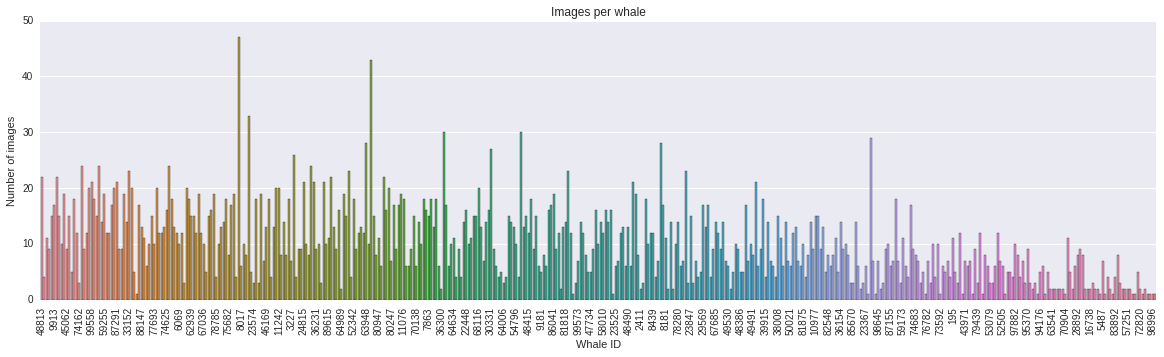

In [17]:
plt.figure(figsize=(20, 5))
# plt.title('Local train / test split')
# _ = plt.hist(y_train, bins=range(447), label='train')
# _ = plt.hist(y_test, bins=range(447), label='valid/test')
# plt.legend()

# _ = plt.hist(y, bins=range(447))
_ = sns.countplot(y)
plt.title('Images per whale')
plt.ylabel('Number of images')
plt.xlabel('Whale ID')
_ = plt.xticks(range(0, 447, 5), rotation=90)

## Feature vectors sparsity?

Turns out it's not sparse at all?

In [18]:
# plt.figure(figsize=(20, 10))
# for i in range(X_train.shape[1]):
#     plt.scatter([i] * X_train.shape[0], X_train.T[i], lw=0, s=0.1, alpha=0.5)
# plt.xlim(0, X_train.shape[1])

## Train ensemble model

In [5]:
def get_actual_pred_proba(raw_pred_proba):
    pred_proba = np.zeros((len(raw_pred_proba), 447))
    for i, label in enumerate(np.unique(y_train)):
        pred_proba[:, label] = raw_pred_proba[:, i]
    return pred_proba

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier

clf = Pipeline([
    ('preprocessing', StandardScaler()),
#     ('pca', RandomizedPCA(n_components=500, random_state=42, whiten=True)),
#     ('select_best', SelectKBest(k=50)),
    ('clf', LogisticRegression(
        C=10, solver='lbfgs', penalty='l2', multi_class='multinomial', n_jobs=-1
    ))
#     ('pca', RandomizedPCA(n_components=500, random_state=42, whiten=True)),

#     ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10))

#     ('clf', GradientBoostingClassifier(n_estimators=500, max_depth=100))

#     ('clf', XGBClassifier(n_estimators=10, max_depth=10, nthread=-1))
])

clf.fit(X_train, y_train)

y_test_pred_proba_raw = clf.predict_proba(X_test)
y_test_pred_proba = get_actual_pred_proba(y_test_pred_proba_raw)

y_train_pred_proba_raw = clf.predict_proba(X_train)
y_train_pred_proba = get_actual_pred_proba(y_train_pred_proba_raw)

y_test_pred = y_test_pred_proba.argmax(axis=1)
y_train_pred = y_train_pred_proba.argmax(axis=1)

from sklearn.metrics import log_loss, accuracy_score
print(accuracy_score(y_train, y_train_pred))
print(log_loss(y_train_oh, y_train_pred_proba))
print()
print(accuracy_score(y_test, y_test_pred))
print(log_loss(y_test_oh, y_test_pred_proba))
print()
print(accuracy_score(y_test[1::2], y_test_pred[1::2]))
print(log_loss(y_test_oh[1::2], y_test_pred_proba[1::2]))
print()
print(accuracy_score(y_test[::2], y_test_pred[::2]))
print(log_loss(y_test_oh[::2], y_test_pred_proba[::2]))


1.0
0.00107821032126

0.819383259912
0.976248641116

0.838235294118
0.995325705678

0.800586510264
0.957227521025


## Test set

In [38]:
fnames = [
    'model_features/cropped_jan03_gp_X_test_head_crop_localize_pts_dec31_256_tta_20160102.npy',
    'model_features/cropped_dec19_gp_X_test_head_crop_localize_pts_dec31_256_tta_20160102.npy',
    'model_features/cropped_dec21_3_gp_X_test_head_crop_localize_pts_dec31_256_tta_20160102.npy',
    'model_features/cropped_jan02_gp_X_test_head_crop_localize_pts_dec31_256_tta_20160102.npy',
    'model_features/cropped_jan05_2_gp_X_test_head_crop_localize_pts_dec31_256_tta_20160102.npy',
    'model_features/cropped_jan05_4_gp_X_test_head_crop_localize_pts_dec31_256_tta_20160102.npy'
]


X_test = load_feats(fnames)
print(X_test.shape)

(6925, 896)


In [43]:
y_test_pred_proba_raw = clf.predict_proba(X_test)
y_test_pred_proba = get_actual_pred_proba(y_test_pred_proba_raw)
y_test_pred_kaggle = y_test_pred_proba.argmax(axis=1)
print(y_test_pred_proba.shape)

(6925, 447)


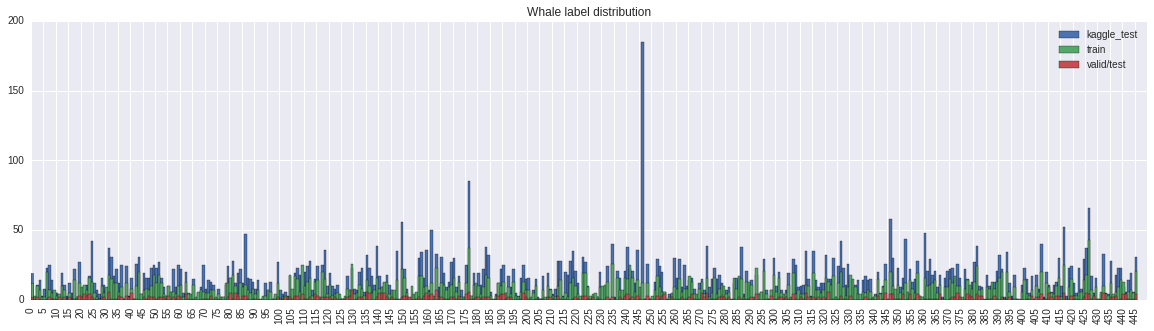

In [52]:
plt.figure(figsize=(20, 5))
plt.title('Whale label distribution')
_ = plt.hist(y_test_pred_kaggle, bins=range(447), label='kaggle_test')
_ = plt.hist(y_train, bins=range(447), label='train')
_ = plt.hist(y_test, bins=range(447), label='valid/test')
plt.xticks(range(0, 447, 5), rotation=90)
plt.legend()

In [23]:
sample_df = pd.read_csv('data/sample_submission.csv')
fnames = sample_df[['Image']].values
values = np.hstack([fnames, y_test_pred_proba])
enc = pickle.load(open('models/encoder.pkl', 'r'))
classes = map(lambda x: 'whale_%05d' % x, enc.classes_)
submission_df = pd.DataFrame(values, columns=['Image'] + classes)
submission_df.head()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
0,w_1947.jpg,4.62177e-07,2.4982e-06,2.13858e-09,1.9698e-07,3.53045e-06,1.06721e-08,6.42469e-11,1.32934e-07,2.21561e-06,...,2.8903e-08,3.88715e-09,1.45791e-06,1.26191e-07,1.41827e-06,1.90436e-09,1.27925e-06,7.49336e-09,5.62845e-05,8.83333e-10
1,w_11096.jpg,1.79381e-07,9.94217e-07,4.62626e-06,0.000664814,2.72603e-06,7.63611e-07,4.62323e-05,2.14121e-05,8.63385e-07,...,0.00039876,8.38886e-05,3.65617e-07,1.89239e-06,1.16214e-05,4.04947e-06,0.000211509,0.000190906,1.12128e-06,0.000147211
2,w_10973.jpg,6.7985e-14,4.72321e-12,1.31816e-06,1.54501e-07,1.4797e-06,9.22233e-13,3.60409e-08,2.44495e-08,1.22304e-07,...,1.10348e-06,6.33105e-13,5.96776e-09,9.47911e-11,2.00573e-07,1.33875e-09,7.28229e-10,1.07135e-08,8.55522e-09,1.69497e-10
3,w_10442.jpg,8.76626e-05,0.000164249,1.74374e-10,1.44835e-10,1.01194e-09,2.50077e-05,6.75644e-09,7.23543e-11,1.00274e-09,...,5.09917e-11,1.11511e-09,1.33061e-10,6.79486e-07,3.9794e-10,5.80689e-12,2.38937e-09,8.23474e-11,1.06872e-10,7.40037e-09
4,w_10606.jpg,1.2579e-07,5.20363e-08,0.000377252,1.86292e-06,4.68395e-08,3.17173e-05,3.99626e-06,4.4148e-07,1.44785e-08,...,6.374e-08,9.92816e-06,3.13352e-05,1.72052e-05,1.17462e-07,2.76364e-05,2.39835e-06,5.58061e-07,1.48982e-06,9.7825e-07


In [24]:
def get_current_timestamp():
    return strftime('%Y%m%d_%H%M%S')

submission_fname = 'submissions/stacking_%s.csv' % get_current_timestamp()
print(submission_fname)

submission_df.to_csv(submission_fname, index=False)

submissions/stacking_20160107_203138.csv
